In [1]:
import os

import psycopg
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

TABLE_NAME = "users_churn" # таблица с данными в postgres 

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = "bvv_43" # напишите название вашего эксперимента
RUN_NAME = "eda"

ASSETS_DIR = "assets"

#os.mkdir(ASSETS_DIR) # или 
os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid") 

In [2]:
# загружаем данные
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
        data = cur.fetchall()
        columns = [col[0] for col in cur.description]

df = pd.DataFrame(data, columns=columns)

df.head(2) 

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,2,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0
1,59,3957-SQXML,2017-04-01,NaT,Two year,No,Credit card (automatic),24.95,894.3,None,None,None,None,None,None,None,Female,0,Yes,Yes,Yes,0


/tmp/ipykernel_1998/410334882.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45)


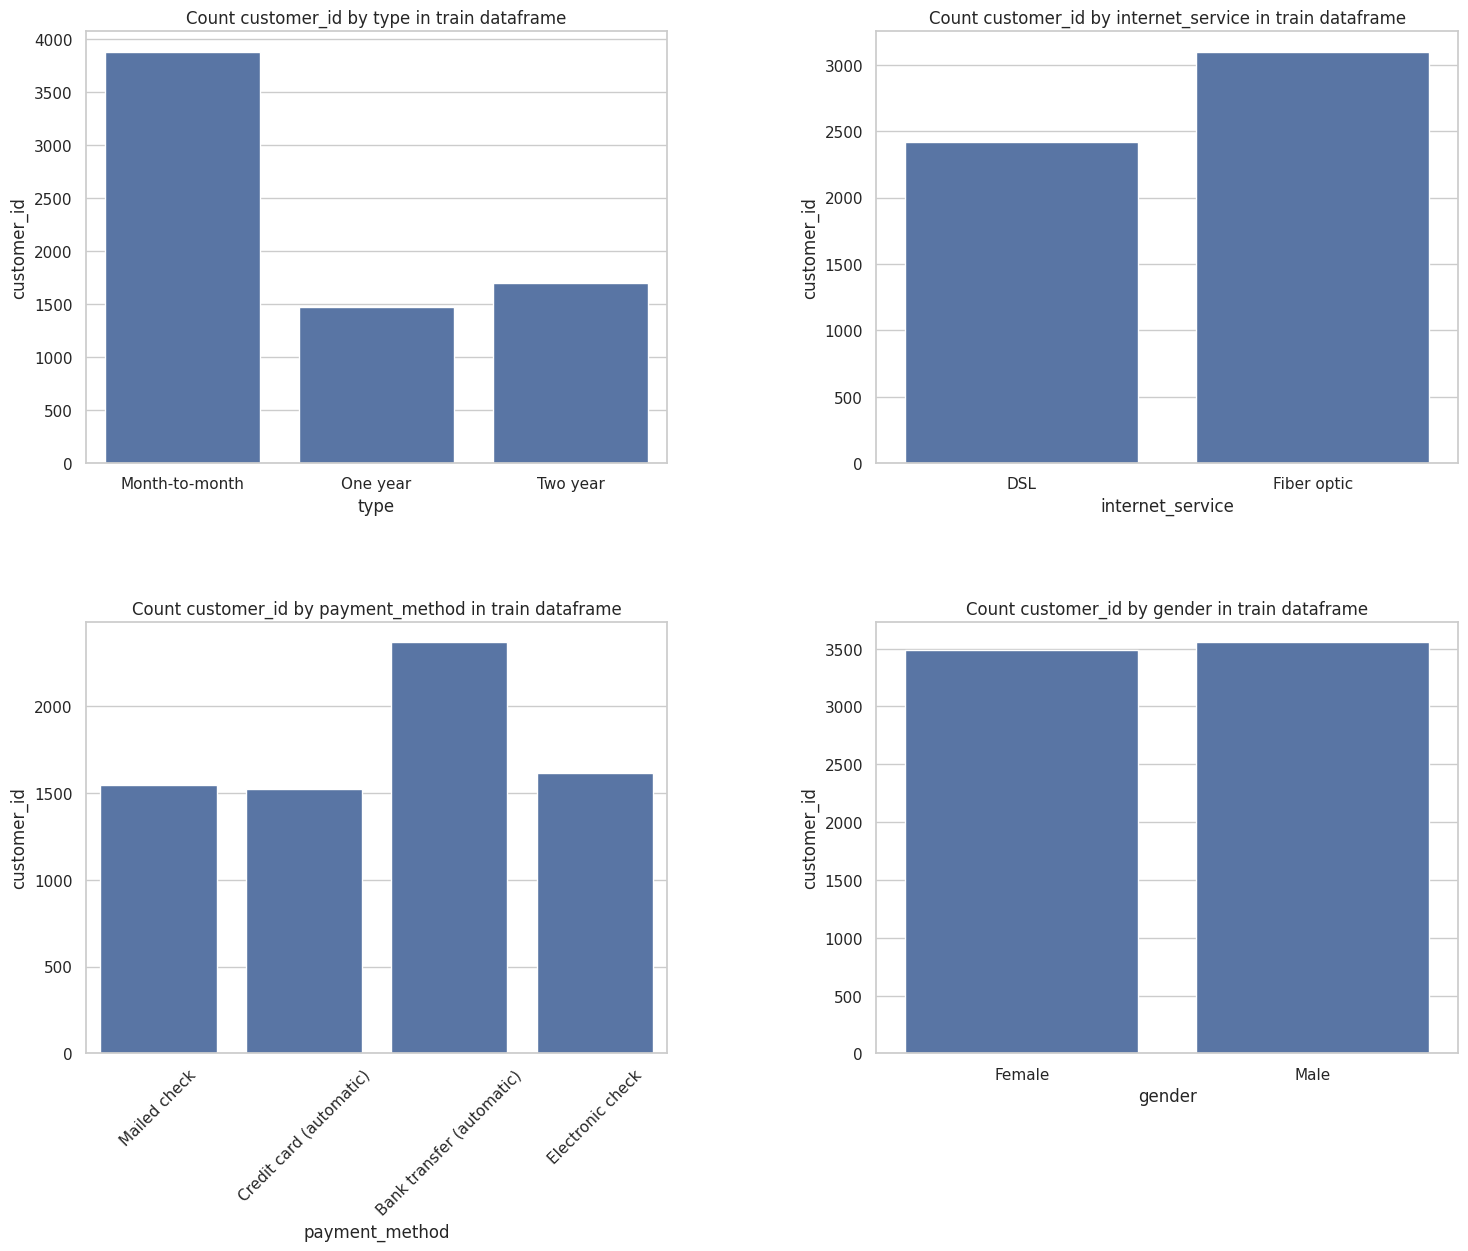

In [3]:
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)
fig.set_size_inches(16.5, 12.5, forward=True)

x = "type"
y = "customer_id"
stat = ["count"]
agg_df =  pd.DataFrame(df.groupby(x).agg({y: stat[0]})).reset_index()
#sns.histplot(data=df, x=x, ax=axs[0, 0])
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 0])
axs[0, 0].set_title(f'Count {y} by {x} in train dataframe')

x = "payment_method"
agg_df =  pd.DataFrame(df.groupby(x).agg({y: stat[0]})).reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 0])
axs[1, 0].set_title(f'Count {y} by {x} in train dataframe')
axs[1, 0].set_xticklabels(df[x].unique(), rotation = 45)

x = "internet_service"
agg_df =  pd.DataFrame(df.groupby(x).agg({y: stat[0]})).reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[0, 1])
axs[0, 1].set_title(f'Count {y} by {x} in train dataframe')
#axs[0, 1].set_xticklabels(df[x].unique(), rotation = 45)

x = "gender"
agg_df =  pd.DataFrame(df.groupby(x).agg({y: stat[0]})).reset_index()
sns.barplot(data=agg_df, x=x, y=y, ax=axs[1, 1])
axs[1, 1].set_title(f'Count {y} by {x} in train dataframe')
#axs[1, 1].set_xticklabels(df[x].unique(), rotation = 45)

plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_1'))

In [70]:
x = "customer_id"
binary_columns = [
    "online_security", 
    "online_backup", 
    "device_protection", 
    "tech_support",
    "streaming_tv",
    "streaming_movies",
    "senior_citizen",
    "partner",
    "dependents",
]
stat = ["count"]
df.groupby(binary_columns).agg({x: stat[0]}).reset_index().sort_values(x, ascending=False).head(10)
#df.groupby(binary_columns).agg(stat[0])[x].reset_index().sort_values(by=x, ascending=False).head(10) - так в ответе

,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,senior_citizen,partner,dependents,customer_id
0,No,No,No,No,No,No,0,No,No,371
106,No,Yes,No,No,No,No,0,No,No,105
414,Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,Yes,103
4,No,No,No,No,No,No,1,No,No,101
8,No,No,No,No,No,Yes,0,No,No,90
15,No,No,No,No,Yes,No,0,No,No,86
214,Yes,No,No,No,No,No,0,No,No,83
22,No,No,No,No,Yes,Yes,0,No,No,82
413,Yes,Yes,Yes,Yes,Yes,Yes,0,Yes,No,75
3,No,No,No,No,No,No,0,Yes,Yes,68


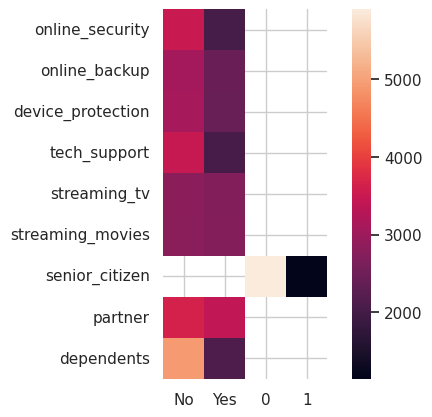

In [97]:
import numpy as np
heat_df = df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df, square=True ) 
plt.savefig(os.path.join(ASSETS_DIR, 'cat_features_2_binary_heatmap'))

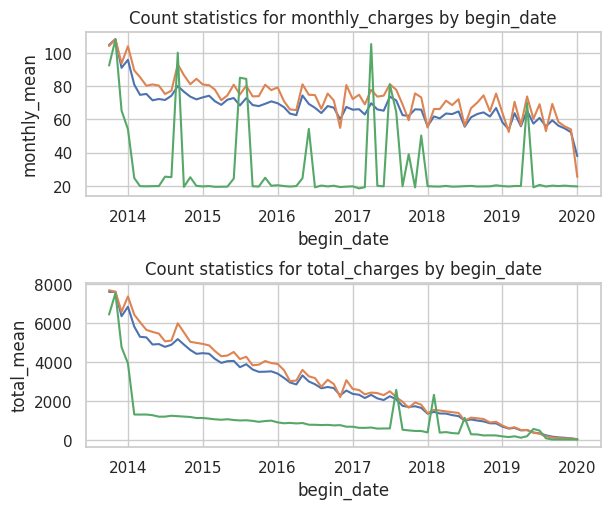

In [ ]:
# инициализация переменной для названия колонки
x = "begin_date"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "monthly_charges",
    "total_charges",
]

# удаление пустых колонок для посчёта медианного значения
df.dropna(subset=charges_columns, how='any', inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик для ежемесячных платежей (используйте reset_index для сброса индекса в таблице)
charges_monthly_agg = pd.DataFrame(df.groupby(x).agg({charges_columns[0]: stats})).reset_index()
#charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index() # 2 вариант
# удаление верхнего уровня индекса колонок (после агрегации)
charges_monthly_agg.columns = charges_monthly_agg.columns.droplevel()
# переименование колонок для удобства восприятия
charges_monthly_agg.columns = [x, "monthly_mean", "monthly_median", "monthly_mode"]

# аналогично для общих платежей
charges_total_agg = pd.DataFrame(df.groupby(x).agg({charges_columns[1]: stats})).reset_index()
charges_total_agg.columns = charges_total_agg.columns.droplevel()
charges_total_agg.columns = [x, "total_mean", "total_median", "total_mode"]

# создание объекта для отображения графиков (2 графика вертикально)
fig, axs = plt.subplots(2, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(6.5, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
#sns.lineplot(x=charges_monthly_agg[charges_monthly_agg.columns[0]], y=charges_monthly_agg[charges_monthly_agg.columns[1]]) - мой вариант
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mean')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_median')
sns.lineplot(charges_monthly_agg, ax=axs[0], x=x, y='monthly_mode')
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

# построение линейных графиков для общих платежей
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mean')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_median')
sns.lineplot(charges_total_agg, ax=axs[1], x=x, y='total_mode')
# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")


plt.savefig(os.path.join(ASSETS_DIR, 'charges_by_date'))

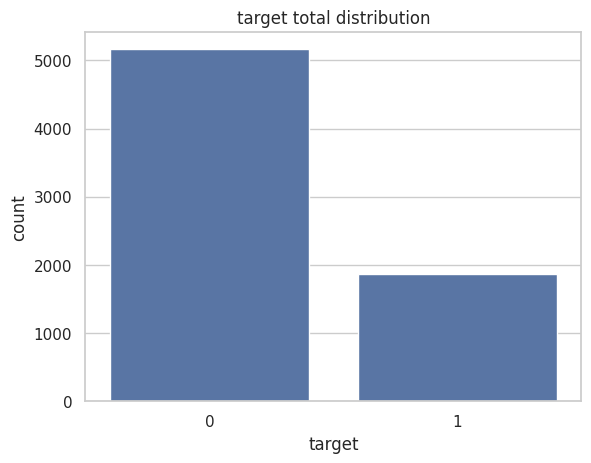

In [158]:
x = "target"
stats = ["count"]

target_agg = df[x].value_counts().reset_index()
#charges_monthly_agg = pd.DataFrame(df.groupby(x).agg({charges_columns[0]: stats})).reset_index()
#charges_monthly_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index() # 2 вариант
sns.barplot(data=target_agg, x=x, y=stats[0])
#sns.barplot(data=target_agg, x='index', y='count') второй вариант - ответ в задании, но не работает
plt.title(f"{x} total distribution")

plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

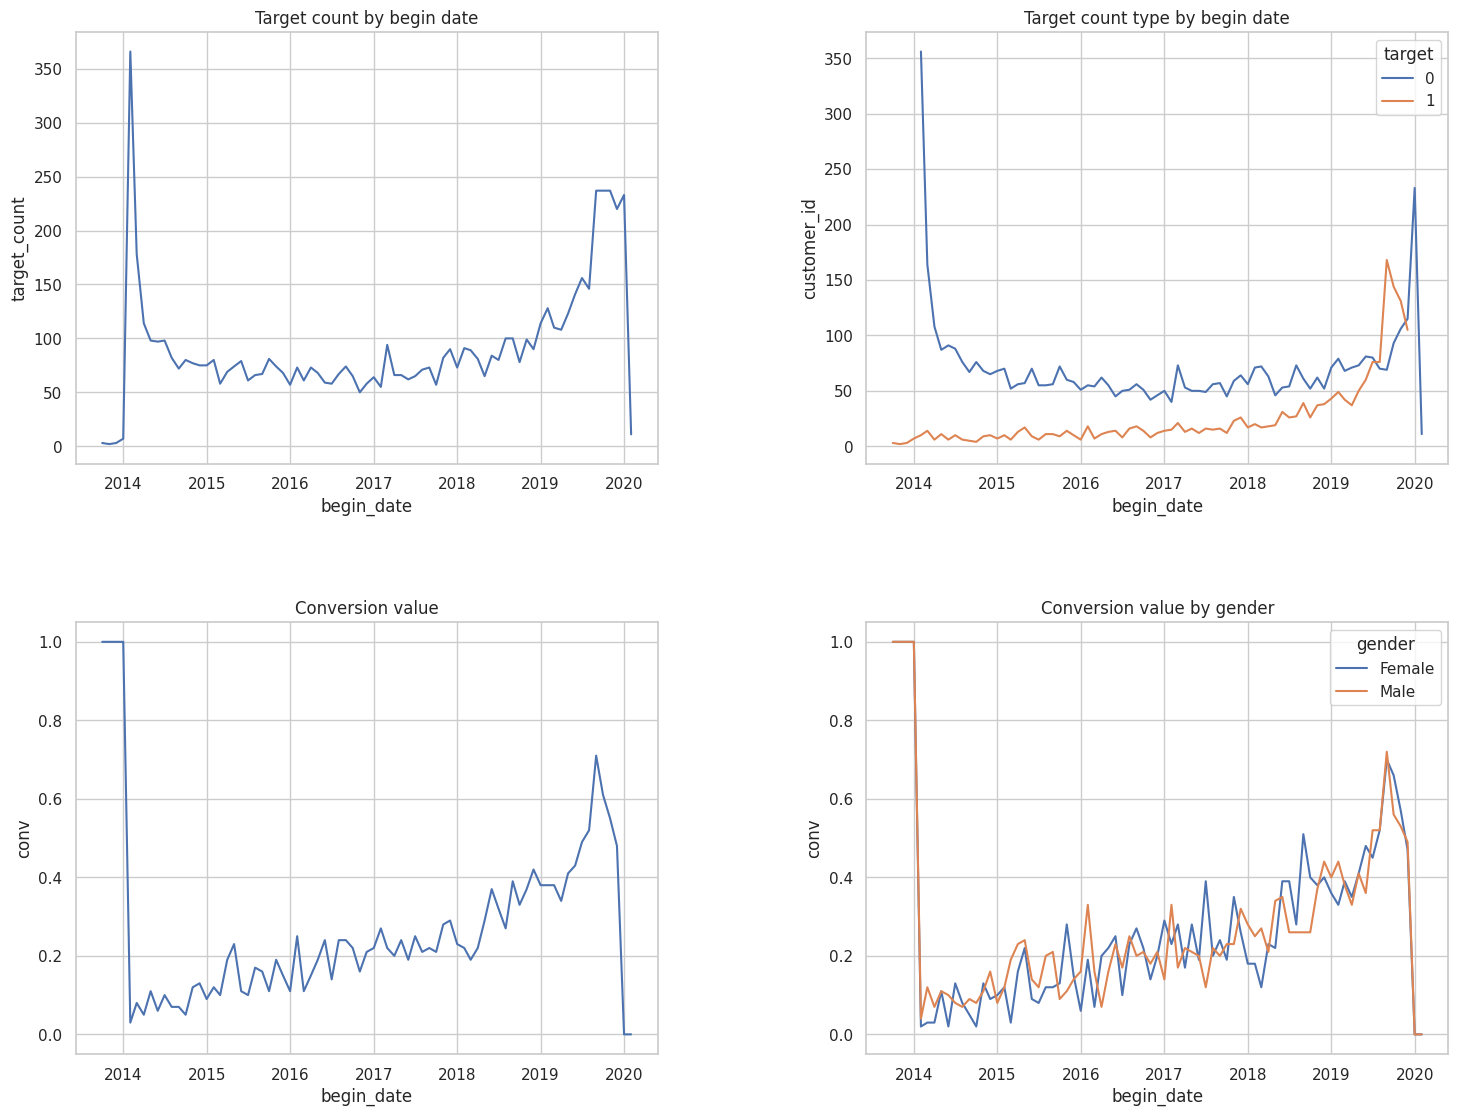

In [4]:
# установка переменных для анализа
x = "begin_date"
target = "target"
# определение статистики для агрегации
stat = ["count"]
conversion_agg_conv = df.shape[0]

# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x,target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x,target,'customer_id']].groupby([x,target]).count().reset_index()
#target_agg.columns = target_agg.columns.droplevel()
#target_agg.columns = [x, "target_count"]

# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x,target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg["conv"] = (conversion_agg["sum"]/conversion_agg["count"]).round(2)

# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_gender = df[[x,target,"gender"]].groupby([x, "gender"])[target].agg(['sum', 'count']).reset_index()
conversion_agg_gender["conv"] = (conversion_agg_gender["sum"]/conversion_agg_gender["count"]).round(2)

# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(2, 2)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y='target_count', ax=axs[0, 0])
axs[0, 0].set_title("Target count by begin date")

# визуализация количества клиентов для каждого типа цели по датам
sns.lineplot(data=target_agg, x=x, y="customer_id", hue=target, ax=axs[0, 1])
axs[0, 1].set_title("Target count type by begin date")

# визуализация коэффициента конверсии по датам
# ваш код здесь #
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1, 0])
axs[1, 0].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_gender, x=x, y="conv", hue='gender', ax=axs[1, 1])
axs[1, 1].set_title("Conversion value by gender")

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

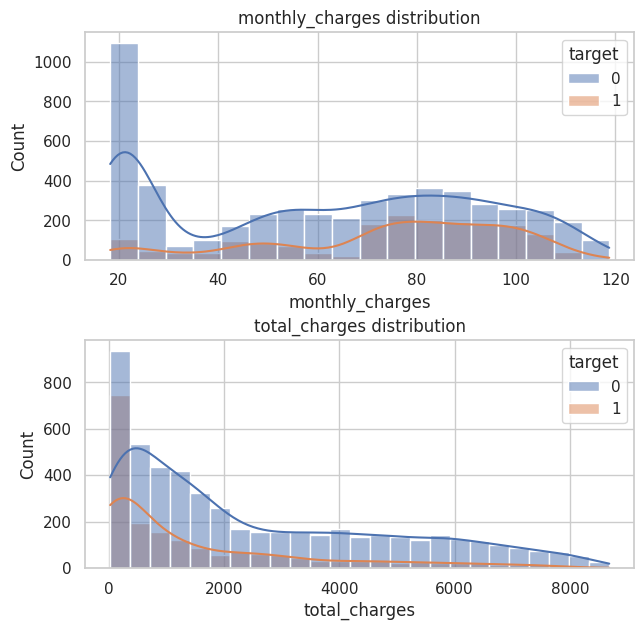

In [ ]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["monthly_charges", "total_charges"]
target = "target"

# инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения ежемесячных платежей с разделением по целевой переменнойы
sns.histplot(data=df, x=charges[0],hue=target, kde=True, ax=axs[0])
# датафрейм с данными
# первый вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения (Kernel Density Estimate)
# указание, на каком подграфике отобразить гистограмму
axs[0].set_title(f"{charges[0]} distribution")  # установка заголовка для гистограммы

# визуализация распределения общих платежей с разделением по целевой переменной
sns.histplot(df, x=charges[1],hue=target, ax=axs[1], kde=True)
# датафрейм с данными
# второй вид платежей для визуализации
# разделение данных по целевой переменной
# включение оценки плотности распределения
# указание, на каком подграфике отобразить вторую гистограмму
axs[1].set_title(f"{charges[1]} distribution")  # Установка заголовка для второй гистограммы

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

In [20]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" #endpoint бакета от YandexCloud
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") # получаем id ключа бакета, к которому подключён MLFlow, из .env
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY") # получаем ключ бакета, к которому подключён MLFlow, из .env

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR) 

In [21]:
run_id

'fde14a321b4441a3874d97a26274413d'

In [11]:
df.head(3)

,id,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,gender,senior_citizen,partner,dependents,multiple_lines,target
0,2,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0
1,59,3957-SQXML,2017-04-01,NaT,Two year,No,Credit card (automatic),24.95,894.30,None,None,None,None,None,None,None,Female,0,Yes,Yes,Yes,0
2,3,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1
